In [ ]:
#!/usr/bin/env python

"""
Name:Sandeep Padhi
Date:10/11/2020

This Python code is based on Java code by Lee Jacobson found in an article
entitled "Applying a genetic algorithm to the travelling salesman problem"
that can be found at: http://goo.gl/cJEY1
"""

# Travelling salesman Problem Genetic Algorithm

import math
import random


class City:
   def __init__(self, x=None, y=None):
      self.x = None
      self.y = None
      if x is not None:
         self.x = x
      else:
         self.x = int(random.random() * 200)
      if y is not None:
         self.y = y
      else:
         self.y = int(random.random() * 200)
   
   def getX(self):
      return self.x
   
   def getY(self):
      return self.y
   
   def distanceTo(self, city):
      xDistance = abs(self.getX() - city.getX())
      yDistance = abs(self.getY() - city.getY())
      distance = math.sqrt( (xDistance*xDistance) + (yDistance*yDistance) )
      return distance
   
   def __repr__(self):
      return str(self.getX()) + ", " + str(self.getY())


class TourManager:
   destinationCities = []
   
   def addCity(self, city):
      self.destinationCities.append(city)
   
   def getCity(self, index):
      return self.destinationCities[index]
   
   def numberOfCities(self):
      return len(self.destinationCities)


class Tour:
   def __init__(self, tourmanager, tour=None):
      self.tourmanager = tourmanager
      self.tour = []
      self.fitness = 0.0
      self.distance = 0
      if tour is not None:
         self.tour = tour
      else:
         for i in range(0, self.tourmanager.numberOfCities()):
            self.tour.append(None)
   
   def __len__(self):
      return len(self.tour)
   
   def __getitem__(self, index):
      return self.tour[index]
   
   def __setitem__(self, key, value):
      self.tour[key] = value
   
   def __repr__(self):
      geneString = "|"
      for i in range(0, self.tourSize()):
         geneString += str(self.getCity(i)) + "|"
      return geneString
   
   def generateIndividual(self):
      for cityIndex in range(0, self.tourmanager.numberOfCities()):
         self.setCity(cityIndex, self.tourmanager.getCity(cityIndex))
      random.shuffle(self.tour)
   
   def getCity(self, tourPosition):
      return self.tour[tourPosition]
   
   def setCity(self, tourPosition, city):
      self.tour[tourPosition] = city
      self.fitness = 0.0
      self.distance = 0
   
   def getFitness(self):
      if self.fitness == 0:
         self.fitness = 1/float(self.getDistance())
      return self.fitness
   
   def getDistance(self):
      if self.distance == 0:
         tourDistance = 0
         for cityIndex in range(0, self.tourSize()):
            fromCity = self.getCity(cityIndex)
            destinationCity = None
            if cityIndex+1 < self.tourSize():
               destinationCity = self.getCity(cityIndex+1)
            else:
               destinationCity = self.getCity(0)
            tourDistance += fromCity.distanceTo(destinationCity)
         self.distance = tourDistance
      return self.distance
   
   def tourSize(self):
      return len(self.tour)
   
   def containsCity(self, city):
      return city in self.tour


class Population:
   def __init__(self, tourmanager, populationSize, initialise):
      self.tours = []
      for i in range(0, populationSize):
         self.tours.append(None)
      
      if initialise:
         for i in range(0, populationSize):
            newTour = Tour(tourmanager)
            newTour.generateIndividual()
            self.saveTour(i, newTour)
      
   def __setitem__(self, key, value):
      self.tours[key] = value
   
   def __getitem__(self, index):
      return self.tours[index]
   
   def saveTour(self, index, tour):
      self.tours[index] = tour
   
   def getTour(self, index):
      return self.tours[index]
   
   def getFittest(self):
      fittest = self.tours[0]
      for i in range(0, self.populationSize()):
         if fittest.getFitness() <= self.getTour(i).getFitness():
            fittest = self.getTour(i)
      return fittest
   
   def populationSize(self):
      return len(self.tours)


class GA:
   def __init__(self, tourmanager):
      self.tourmanager = tourmanager
      self.mutationRate = 0.015
      self.tournamentSize = 5
      self.elitism = True
   
   def evolvePopulation(self, pop):
      newPopulation = Population(self.tourmanager, pop.populationSize(), False)
      elitismOffset = 0
      if self.elitism:
         newPopulation.saveTour(0, pop.getFittest())
         elitismOffset = 1
      
      for i in range(elitismOffset, newPopulation.populationSize()):
         parent1 = self.tournamentSelection(pop)
         parent2 = self.tournamentSelection(pop)
         child = self.crossover(parent1, parent2)
         newPopulation.saveTour(i, child)
      
      for i in range(elitismOffset, newPopulation.populationSize()):
         self.mutate(newPopulation.getTour(i))
      
      return newPopulation
   
   def crossover(self, parent1, parent2):
      child = Tour(self.tourmanager)
      
      startPos = int(random.random() * parent1.tourSize())
      endPos = int(random.random() * parent1.tourSize())
      
      for i in range(0, child.tourSize()):
         if startPos < endPos and i > startPos and i < endPos:
            child.setCity(i, parent1.getCity(i))
         elif startPos > endPos:
            if not (i < startPos and i > endPos):
               child.setCity(i, parent1.getCity(i))
      
      for i in range(0, parent2.tourSize()):
         if not child.containsCity(parent2.getCity(i)):
            for ii in range(0, child.tourSize()):
               if child.getCity(ii) == None:
                  child.setCity(ii, parent2.getCity(i))
                  break
      
      return child
   
   def mutate(self, tour):
      for tourPos1 in range(0, tour.tourSize()):
         if random.random() < self.mutationRate:
            tourPos2 = int(tour.tourSize() * random.random())
            
            city1 = tour.getCity(tourPos1)
            city2 = tour.getCity(tourPos2)
            
            tour.setCity(tourPos2, city1)
            tour.setCity(tourPos1, city2)
   
   def tournamentSelection(self, pop):
      tournament = Population(self.tourmanager, self.tournamentSize, False)
      for i in range(0, self.tournamentSize):
         randomId = int(random.random() * pop.populationSize())
         tournament.saveTour(i, pop.getTour(randomId))
      fittest = tournament.getFittest()
      return fittest



if __name__ == '__main__':
   
   tourmanager = TourManager()
   
   # Create and add our cities
   city = City(60, 200)
   tourmanager.addCity(city)
   city2 = City(180, 200)
   tourmanager.addCity(city2)
   city3 = City(80, 180)
   tourmanager.addCity(city3)
   city4 = City(140, 180)
   tourmanager.addCity(city4)
   city5 = City(20, 160)
   tourmanager.addCity(city5)
   city6 = City(100, 160)
   tourmanager.addCity(city6)
   city7 = City(200, 160)
   tourmanager.addCity(city7)
   city8 = City(140, 140)
   tourmanager.addCity(city8)
   city9 = City(40, 120)
   tourmanager.addCity(city9)
   city10 = City(100, 120)
   tourmanager.addCity(city10)
   city11 = City(180, 100)
   tourmanager.addCity(city11)
   city12 = City(60, 80)
   tourmanager.addCity(city12)
   city13 = City(120, 80)
   tourmanager.addCity(city13)
   city14 = City(180, 60)
   tourmanager.addCity(city14)
   city15 = City(20, 40)
   tourmanager.addCity(city15)
   city16 = City(100, 40)
   tourmanager.addCity(city16)
   city17 = City(200, 40)
   tourmanager.addCity(city17)
   city18 = City(20, 20)
   tourmanager.addCity(city18)
   city19 = City(60, 20)
   tourmanager.addCity(city19)
   city20 = City(160, 20)
   tourmanager.addCity(city20)
   
   # Initialize population
   pop = Population(tourmanager, 50, True);
   print("Initial distance: " + str(pop.getFittest().getDistance()))
   
   # Evolve population for 50 generations
   ga = GA(tourmanager)
   pop = ga.evolvePopulation(pop)
   for i in range(0, 100):
      pop = ga.evolvePopulation(pop)
   
   # Print final results
   print("Finished")
   print("Final distance: " + str(pop.getFittest().getDistance()))
   print("Solution:")
print(pop.getFittest())

Initial distance: 1821.712209843501
Finished
Final distance: 1011.2019018999249
Solution:
|60, 20|20, 20|20, 40|20, 160|60, 200|80, 180|140, 180|180, 200|200, 160|180, 100|180, 60|200, 40|160, 20|100, 40|120, 80|140, 140|100, 160|100, 120|40, 120|60, 80|


#item                       Weight          survivalPoints
Sleeping bag        15                   15
Rope                          3                    7
Pocketknife           2                    10
Torch                       5                     5
Bottle                      9                      8



GeneratePopulation:40
valid: 0 , [0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1]
valid: 1 , [0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0]
valid: 2 , [0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
valid: 3 , [0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0]
valid: 4 , [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0]
valid: 5 , [0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1]
valid: 6 , [0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1]
valid: 7 , [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0]
jyada ho gaya
jyada ho gaya
valid: 8 , [0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0]
jyada ho gaya
valid: 9 , [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
valid: 10 , [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
valid: 11 , [0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
valid: 12 , [0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
valid: 13 , [1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0]
valid: 14 , [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
valid: 15 , [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
valid: 16 , [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0]
valid: 17 , [0 1 1 0 0 0 0 0

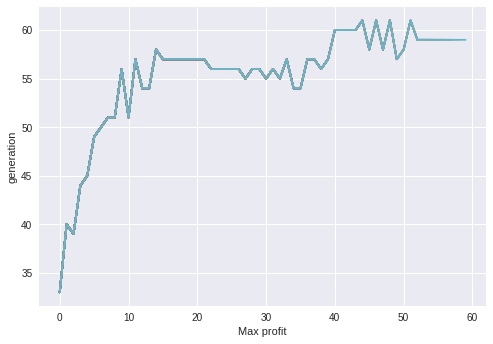

In [ ]:


# 0/1 Knapsack Problem using Genetic Algorithm

'''
#item                       Weight          survivalPoints
Sleeping bag                  15                   15
Rope                          3                     7
Pocketknife                   2                    10
Torch                         5                     5
Bottle                        9                      8
Glucose                       20                     17
'''

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep


items={1:"Sleeping_bag",2:"Rope",3:"Pocketknife",4:"Torch",5:"Bottle",6:"Glucose",7:"football",8:"Ring",9:"Oil",10:"Pencil",11:"TV",12:"books",13:"Medicines",14:"watch",15:"mobile",16:"Water",17:"biscuit",18:"Sunscreen",19:"Ball",20:"candel"}

weight=[15,3,2,5,9,20,3,0.3,2,0.5,20,3,2,2,4,3,2,2,2,2]
survivalPoints=[15,7,10,5,8,17,3,1,4,2,0.2,3,7,4,8,4,3,2,1,4]
weightlimit=10

no_of_individuals=40
no_of_items=20

  
  
population=np.zeros((no_of_individuals,no_of_items),dtype='int')



def checkvalid(chrome):
  w=0
  for i in range(no_of_items):
    if chrome[i]==1:
      w=w+weight[i]
  if w<=30:
    return True
  #print("weight is {}".format(w))
  return False


def GeneratePopulation(no_of_individual):
  global population
  print("GeneratePopulation:{}".format(no_of_individual))
  i=0
  epsolon=0.8
  iter=0
  while(i<no_of_individual):
    pop=np.copy(population[i])
    #print("pop:{}".format(pop))
    #print(np.random.uniform(0,1))
    iter=iter+1
    for j in range(no_of_items):
      if np.random.uniform(0,1)>epsolon:
        pop[j]=1
        
    if checkvalid(pop):
      population[i]=pop
      print("valid: {} , {}".format(i,pop))
      
      i=i+1
      continue
    #print("i is {} , iter is {}".format(i,iter)) 
    if iter>5 :
      print("jyada ho gaya")
      n=np.random.randint(0,no_of_items)
      pop[n]=1
      if checkvalid(pop):
        print("calega {}".format(i))
        print("valid: {} , {}".format(i,pop))
        population[i]=pop

        i=i+1
        iter=0
    
    
#GeneratePopulation(no_of_individuals)    
#print("population is {}".format(population))
best=[]
bestfitness=-99
Fitnessvalue=[]
def Fitness():
   global best,bestfitness  
  
   for i in range(no_of_individuals):
    pop=np.copy(population[i])
    v=0
    for i in range(no_of_items):
      if pop[i]==1:
        v=v+survivalPoints[i]
    if checkvalid(pop):
      #print("fitness valid hai re..")
      if v>bestfitness:
        bestfitness=v
        best=np.copy(pop)
    else:
      #print("illegal.. hai fitness")
      pass
    #print(v)
    Fitnessvalue.append(v)
    
    
Fitness()
#print("fitness is {}".format(Fitnessvalue))
  
parentstomutate=[]
fitparent=[]
no_of_parent_fit=4
doneindex=[-1]

def SelectParents():
  global doneindex
  m=Fitnessvalue
  m=sorted(m)
  #print(m)
  #print(Fitnessvalue)
  '''
  for i in range(no_of_individuals):
    if checkvalid(population[i]):
      print("{} is valid parent".format(i))
    else:
      print("{} is invalid parent".format(i))
  '''    
 
  fitparent=m[-4:]
  for i in fitparent:
    for key,value in enumerate(Fitnessvalue):
      if i==value and key not in doneindex:
        parentstomutate.append(population[key])
        doneindex.append(key)
        
    
  
  doneindex=[]
  fitparent=[]
  
  

#SelectParents()
#print("parents to mutate:{}".format(parentstomutate))
crossoverpoint=int(no_of_items/2)


offspring=[]

def Crossover():
  no_of_offspring=no_of_individuals-no_of_parent_fit
  i=0
  
  while(i<no_of_offspring):
    parent1=np.random.randint(0,no_of_individuals)
    parent2=np.random.randint(0,no_of_individuals)
    #print("parent 1 part {}".format(population[parent1][:crossoverpoint]))
    #print("parent 2 part {}".format(population[parent2][crossoverpoint:]))

    offspr=np.concatenate((population[parent1][0:crossoverpoint],population[parent2][crossoverpoint:]),axis=0)
    #print("offspring to check {}".format(offspr))
    if checkvalid(offspr):
      offspring.append(offspr)
      #print("cross over {}".format(i))
      i=i+1
  #print("PRODUCED {} OFFSPRINGS".format(len(offspring)))
  #print(offspring)
  
  
#Crossover()

#print("parents to mutate:{} len:{}".format(parentstomutate,np.shape(parentstomutate)[0]))
#print("offspring:{} len {}".format(offspring,np.shape(offspring)[0]))
#population=parentstomutate+offspring
#print("new population is {}".format(population))
#print("len {}".format(np.shape(population)[0]))


def mutate():
  #print("Entered mutate")
  for i in range(no_of_individuals):
    n=np.random.randint(0,no_of_items)
    m=np.copy(population[i])
    m[n]=(m[n]+1)%2
    '''
    if (population[i]==m).all():
      print(" same {}".format(i))
    '''
    if checkvalid(m):
      #print("valid mutate {}".format(i))
      population[i]=m
      
    if checkvalid(population[i]):
      #print("mutate {}".format(i))
      pass
      #print("mutate :{}".format(population[i]))
    
#mutate()
population=np.array(population)
#print("After mutation {}".format(population))    
Fitnessvalue=[]
#Fitness()  
#print("fitness is {}".format(Fitnessvalue))


no_of_generation=60
population=np.zeros((no_of_individuals,no_of_items),dtype='int')
GeneratePopulation(no_of_individuals)

#best=[]
#bestfitness=-99

gen=[]
fitness=[]
for i in range(no_of_generation):
  
  Fitnessvalue=[]
  Fitness()
  #print("max index is {}".format(np.argmax(Fitnessvalue)))
  #print("checking fitness{}".format(checkvalid(population[np.argmax(Fitnessvalue)])))
  
  parentstomutate=[]
  offspring=[]
  
  
  
  fitparent=[]
  no_of_parent_fit=4
  doneindex=[-1]
  SelectParents()
  
  crossoverpoint=int(no_of_items/2)
  offspring=[]
  Crossover()
  population=parentstomutate+offspring
  
  
  '''
  print("checking parentstomutate")
  for i in range(np.shape(parentstomutate)[0]):
    if checkvalid(parentstomutate[i]):
      print("parentstomutate {} valid".format(i))
    else:
      print("parentstomutate {} invalid".format(i))
  
  print("Checking validiing after crossover")
  for i in range(no_of_individuals):
    if checkvalid(population[i]):
      print(" {} valid".format(i))
    else:
      print("{} invalid".format(i))
  '''  

  #Fitnessvalue=[]
  #Fitness()
 
  mutate()
  '''
  print("Checking validiing after mutation")
  for i in range(no_of_individuals):
    if checkvalid(population[i]):
      print(" {} valid".format(i))
    else:
      print("{} invalid".format(i))
    
  '''
  
  #print("fitness for iteration {} is {}".format(i,Fitnessvalue))
  gen.append(i)
  fitness.append(max(Fitnessvalue))
  sleep(.1)
  #clear_output()
  #print("fitness max is {}".format(max(Fitnessvalue)))
  plt.xlabel("Max profit")
  plt.ylabel("generation")
  plt.plot(gen,fitness)

  #plt.show()
  if np.max(Fitnessvalue) > bestfitness and checkvalid(population[np.argmax(Fitnessvalue)]):
    best=population[np.argmax(Fitnessvalue)]
    bestfitness=np.max(Fitnessvalue)
    
  
  if len(best)>0:
    #print("check best:{}".format(checkvalid(best)))
    pass
print("Best fitness is {}".format(bestfitness))
print("best population is {}".format(best))
print("check best:{}".format(checkvalid(best)))
f=0

for i in range(no_of_items):
  if best[i]==1:
    f=f+survivalPoints[i]
print("it is {} ".format(f))
print("items to cary is {}".format( [items[key+1] for key,value in enumerate(best) if value==1] ))

      



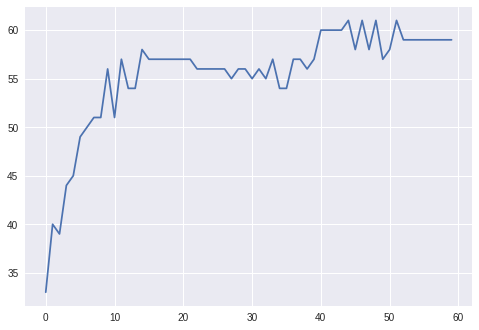

Total generation of population:60
Weight limit:10
Max profit is 61
Following items to carry out of 20 available items: 
items to cary is ['Rope', 'Pocketknife', 'Torch', 'Ring', 'Oil', 'Pencil', 'Medicines', 'watch', 'mobile', 'Water', 'biscuit', 'Sunscreen', 'candel']


In [ ]:
clear_output()
  #print("fitness max is {}".format(max(Fitnessvalue)))
plt.plot(gen,fitness)
plt.show()
print("Total generation of population:{}".format(no_of_generation))
print("Weight limit:{}".format(weightlimit))
print("Max profit is {}".format(bestfitness))
print("Following items to carry out of {} available items: ".format(no_of_items))
print("items to cary is {}".format( [items[key+1] for key,value in enumerate(best) if value==1] ))


In [ ]:

Iteration no                 Max Profit
 1.                               60
  

[1, 2, 3, 3, 4, 5]
